In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics_2016.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')

#create mkt share data
blp_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices','demand_instruments0']

nonlinear_cols = ['csr_pay_94','EHBPercentTotalPremium']#,'SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']
#['act_value','csr_pay_94','csr_pay_87','SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']

linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver','Plan Counts']#
#['CompositeRatingOffered_No','MetalLevel_Silver','MetalLevel_Platinum',
# 'BeginPrimaryCareCostSharingAfterNumberOfVisits' , 'csr_tot', 'csr_tot_94', 'PlanType_Indemnity']            
#'CSRVariationTypeBinary','DentalOnlyPlan_No','CompositeRatingOffered_No',

firm_cols =  linear_cols+ nonlinear_cols    
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E','StateCodeFL'] #'DP03_0001PE'


keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

def create_blp_data(df):
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']

    #add blp columns
    df['prices'] = df['PREMI27']
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 
    df['market_ids'] = df['County']
    df['firm_ids'] = df['IssuerId']

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['prices']) #average price across markets


    #fix problematic columns =
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'})

    #'DP05_0072PE', ,

    blp_data = df[blp_keys+linear_cols+nonlinear_cols+mkt_cols+['DP03_0095E']]


    #standardize the cols
    for col in firm_cols:
        #this line is causing a warning?
        blp_data[col] = blp_data[col]/blp_data[col].var()

    #zero shares are not okay?
    blp_data = blp_data[blp_data['shares']!=0]
    return blp_data,df
    
X_train,df1 = create_blp_data(df1)
X_test,df2 = create_blp_data(df2)
X_test  = X_test.fillna(0)

/tmp/ipykernel_364671/1190455877.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blp_data[col] = blp_data[col]/blp_data[col].var()


In [3]:
#split into training and test

model = sm.Logit(X_train['shares'],
                 sm.add_constant(X_train[linear_cols+nonlinear_cols+mkt_cols+['prices']]))
model_fit = model.fit()
print(model_fit.summary())
pred_shares = model_fit.predict(
    sm.add_constant(X_test[linear_cols+nonlinear_cols+mkt_cols+['prices']]))
train_shares = model_fit.predict(
    sm.add_constant(X_train[linear_cols+nonlinear_cols+mkt_cols+['prices']]))

Optimization terminated successfully.
         Current function value: 0.015554
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 shares   No. Observations:                 8017
Model:                          Logit   Df Residuals:                     8005
Method:                           MLE   Df Model:                           11
Date:                Tue, 17 May 2022   Pseudo R-squ.:                     inf
Time:                        11:12:56   Log-Likelihood:                -124.70
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.2532      0.563     -9.327      0.000      -6.357      

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mse 24699109.715316627 r2 0.38665372165390877 var 40269437.65260727
pred 2016 12374212.738298923 actual 2016 9870266.0
pred mean 2016 1543.4966618808628 mean 2016 1231.167020082325
pred 2017 10720091.289945371 actual 2017 9167619.0
pred mean 2017 1977.1470472049743 mean 2017 1690.8187015861306


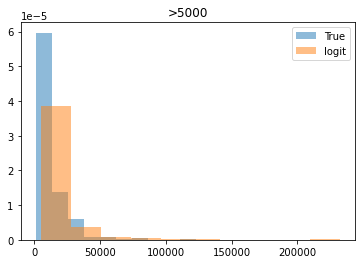

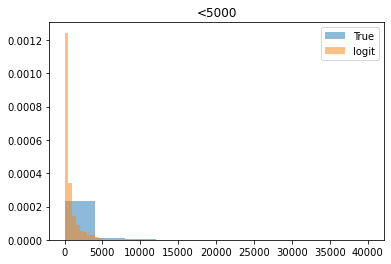

In [4]:
#evaluating model fit...
error = (X_test['shares']- pred_shares)*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']


mse  = float( (error**2).mean() ) 
r2 = float( 1 - (error**2).mean()/true_shares.var() )
print( 'mse', mse, 'r2', r2,'var', true_shares.var())
print('pred 2016',  (train_shares*X_train['DP03_0095E']).sum(),
      'actual 2016', (X_train['DP03_0095E']*X_train['shares']).sum())

print('pred mean 2016',  (train_shares*X_train['DP03_0095E']).mean(),
      'mean 2016', (X_train['DP03_0095E']*X_train['shares']).mean())

print('pred 2017', (pred_shares*X_test['DP03_0095E']).sum() , 'actual 2017', float(true_shares.sum()) )
print('pred mean 2017', (pred_shares*X_test['DP03_0095E']).mean() , 'mean 2017', float(true_shares.mean()) )

blp_pred = pred_shares*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split = 5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()

In [5]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy())
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('_x',''))    
    result = result.sort_values('error',ascending=False).head(50) 
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
IL     95746.836485         47726.333333  23741.634915  28674.570970      3
AZ     55782.212138        102128.000000           NaN           NaN      1
NV     32743.654078          2607.000000           NaN           NaN      1
TX     31294.171380         43531.000000  18399.575804  39703.850465     10
FL     29289.242613         46850.062500   9532.086779  60158.196128     16
PA     28263.532230          5401.000000   8941.155960   7256.329789      2
MI     26961.889518          1863.571429   4038.295461   1242.482174      7
WI     20755.191130          1492.000000           NaN           NaN      1
OH     20018.076787           839.000000           NaN           NaN      1
VA     15688.599406         35581.000000           NaN           NaN      1
OK     13468.327445         32912.000000           NaN           NaN      1
NC     13203

# comparing market structure in the 2 years

       Ever Enrolled Count      prices  MetalLevel_Silver        csr_tot  \
State                                                                      
0               968.750000    0.000000           0.000000    1098.062500   
NE              136.000000  311.953438           0.354167     202.583333   
UT             3209.500000  287.319000           0.400000    2872.333333   
NC             2907.600000  316.941333           0.400000    2882.600000   
TX              130.666667  169.886111           0.333333     131.666667   
VA              660.666667  160.690435           0.347826     613.666667   
FL           201162.000000  226.928667           0.266667  317342.500000   
MO              607.000000  256.775714           0.380952     670.000000   
MT              316.000000  274.047500           0.500000     377.000000   
WI             1086.000000   71.511154           0.551282    1114.000000   

       count  
State         
0         16  
NE        12  
UT         6  
NC         5

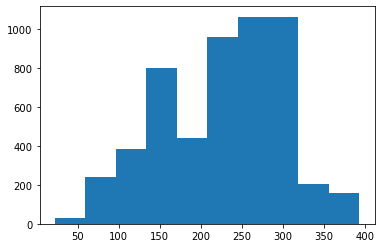

In [6]:
highest_shares = df1[['shares','IssuerId','State',
          'Ever Enrolled Count','DP03_0095E','act_value','prices','MetalLevel_Silver',
    'csr_tot','csr_pay_94']].sort_values('shares',ascending=False).head(50)


highest_share_groupy = highest_shares.groupby('State')[['Ever Enrolled Count','prices','MetalLevel_Silver','csr_tot']].mean()
highest_share_groupy['count'] =highest_shares.groupby('State')['shares'].count()
highest_share_groupy = highest_share_groupy.sort_values('count',ascending=False)
print(highest_share_groupy)

plt.hist(df1['prices'][df1['prices']>=.1])
plt.show()

       Ever Enrolled Count      prices  MetalLevel_Silver  csr_tot  count
State                                                                    
0              1020.250000    0.000000           0.000000      0.0     36
NC             6876.500000  334.591364           0.363636      0.0      4
TX              864.500000  251.822530           0.468623      0.0      4
MT              176.666667  389.911000           0.300000      0.0      3
FL           232412.000000  271.446000           0.400000      0.0      1
VA              197.000000  191.571136           0.363636      0.0      1
WI             2257.000000  318.144000           0.400000      0.0      1


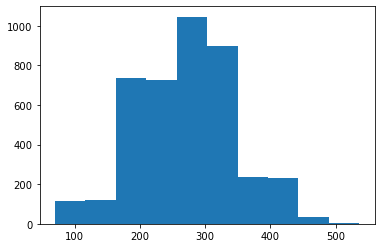

In [7]:
highest_shares = df2[['shares','IssuerId','State','County',
          'Ever Enrolled Count','DP03_0095E','act_value','prices','MetalLevel_Silver',
    'csr_tot','csr_pay_94']].sort_values('shares',ascending=False).head(50)


highest_share_groupy = highest_shares.groupby('State')[['Ever Enrolled Count','prices','MetalLevel_Silver','csr_tot']].mean()
highest_share_groupy['count'] =highest_shares.groupby('State')['shares'].count()
highest_share_groupy = highest_share_groupy.sort_values('count',ascending=False)
print(highest_share_groupy)

plt.hist(df2['prices'][df2['prices']>=.1])
plt.show()